# Variational Inference
> Under the hood
 - layout: post
 - toc: false
 - comments: false
 - hide: false
 - search_exclude: true
 - categories: [fastpages, jupyter]
 - use_math: true

### Purpose
Following the blog post https://willcrichton.net/notes/probabilistic-programming-under-the-hood/

In [2]:
import pyro.distributions as dist
from pyro import sample
import torch

In [10]:
# A fair coin flip
coinflip = sample("coinflip", dist.Bernoulli(probs=0.5))
print(f'coinflip - {coinflip}')

# Noisy sample
noisy_sample = sample("noisy_sample", dist.Normal(loc=0, scale=1))
print(f'Noisy Sample - {noisy_sample}')

coinflip - 1.0
Noisy Sample - -0.21278521418571472


In [42]:
def sleep_model():
    # very likely to feel lazy
    feeling_lazy = sample('feeling_lazy', dist.Bernoulli(0.9))
    if feeling_lazy:
        # only going to possibly ignore alarm if I am feeling lazy
        ignore_alarm = sample('ignore_alarm', dist.Bernoulli(0.8))
        # will sleep more if Ignore alarm
        amount_slept = sample(f'amount_slept', dist.Normal(8 + 2*ignore_alarm, 1))
    else:
        amount_slept = sample('amount_slept', dist.Normal(6, 1))
    return amount_slept

print(sleep_model())
print(sleep_model())
print(sleep_model())
                              

tensor(9.6567)
tensor(8.2041)
tensor(11.7966)


### Traces and conditioning
On the unconditional sleep model, we could ask a few questions, like:

 - Joint probability of a sample: what is the probability that `feeling_lazy` = 1, `ignore_alarm` = 0, amount_slept = 10?
 - Joint probability distribution: what is the probability for any possible assignment to all variables?
 - Marginal probability of a sample: what is the probability that `feeling_lazy` is true?
 - Marginal probability distribution: what is the probability over all values of `amount_slept`?
 
First, we need the ability to evaluate the probability of a joint assignment to each variable. 

In [19]:
from pyro.poutine import trace
from pprint import pprint

In [22]:
# Runs the sleep model and collects a trace
tr = trace(sleep_model).get_trace()
pprint({
    name: {
        'value': props['value'],
        'prob': props['fn'].log_prob(props['value']).exp()
    }
    for (name, props) in tr.nodes.items()
    if props['type'] == 'sample'
})

{'alarm_slept': {'prob': tensor(0.3937), 'value': tensor(7.8368)},
 'feeling_lazy': {'prob': tensor(0.9000), 'value': tensor(1.)},
 'ignore_alarm': {'prob': tensor(0.2000), 'value': tensor(0.)}}


### conditional probabilities

In [27]:
from pyro import condition

cond_model = condition(sleep_model, {
    'feeling_lazy': torch.tensor(1.0),
    'ignore_alarm': torch.tensor(0.0),
    'amount_slept': 10.0
})

trace(cond_model).get_trace().log_prob_sum().exp()

tensor(0.0303)

Now we can produce an approximate answer to any of our questions by sampling from distribution enough times. For example, we can look at the marginal distribution over each variable

array([[<AxesSubplot:title={'center':'feeling_lazy'}>,
        <AxesSubplot:title={'center':'ignore_alarm'}>],
       [<AxesSubplot:title={'center':'amount_slept'}>, <AxesSubplot:>]],
      dtype=object)

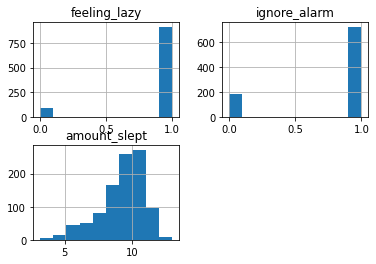

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

traces = []
for _ in range(1000):
    tr = trace(sleep_model).get_trace()
    values = {
        name: props['value'].item()
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    }
    traces.append(values)

df = pd.DataFrame(traces)
df.hist()

In [47]:
df.head(2)

,feeling_lazy,ignore_alarm,amount_slept
0,1.0,1.0,10.285290
1,1.0,1.0,11.648011


### Sampling conditional distributions
 - Given I slept 6 hours, what is the probability I was feeling lazy?
 - What is the probability of me sleeping exactly 7.65 hours
 
 What is the problem with this?
First, as the number of marginalized variables grows, we have an exponential increase in summation terms.

But the second issue is that for continuous variables, computing this marginal probability can quickly become intractable. For example, if `feeling_lazy` was a real-valued laziness score between 0 and 1 (presumably a more realistic model), then marginalizing that variable requires an integral instead of a sum. In general, producing an exact estimate of a conditional probability for a complex probabilistic program is not computationally feasible.

## Approximate Inference
The main idea is that instead of exactly computing the conditional probability distribution (or “posterior”) of interest, we can approximate it using a variety of techniques. Generally, these fall into two camps: sampling methods and variational methods. The CS 228 (Probabilistic Graphical Models at Stanford) course notes go in depth on both ([sampling](https://ermongroup.github.io/cs228-notes/inference/sampling/), [Variational](https://ermongroup.github.io/cs228-notes/inference/variational/))

Essentially, for sampling methods, you use algorithms that continually draw samples from a changing probability distribution until eventually they converge on the true posterior of interest. The time to convergence is not known ahead of time. For variational methods, you use a simpler function that can be optimized to match the true posterior using standard optimization techniques like gradient descent. 

Where to use what? Please have a look at the original blog post. 

### Variational inference 1: autodifferentiation